# housekeeping

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# ! python --version

Python 3.9.16


In [3]:
# !sudo pip install polars

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# !sudo pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# ! sudo pip install numpyro

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 KB 16.8 MB/s eta 0:00:00


In [1]:
import polars as pl
import numpy as np
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import sklearn.metrics
from functools import partial
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az
import pytensor.tensor as at
import numpyro
import jax
import pymc.sampling_jax as pmjax

In [2]:
# lightgbm で使う num_threads の調査のため
import multiprocessing
multiprocessing.cpu_count()

12

In [3]:
# seed
RANDOM_SEED = 1013

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Apr 10 13:59:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    47W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


# 読み込み

データフレームに付けるヘッダーを作る

In [6]:
columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 
           'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
           'Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2', 'Wilderness_Area_3']

In [7]:
Soil_Type = ['Soil_Type']*40
int_series = np.arange(0, 40)

soils = pl.DataFrame({
    'Soil_Type': Soil_Type,
    'int_series': list(int_series)
})

soils = soils.with_columns(
    pl.concat_str([
        pl.col('Soil_Type'),
        pl.col('int_series')
        ], 
        separator='_'
    ).alias("Soil_Type's")
)

all_columns = columns \
    + list(np.concatenate(soils.select(pl.col("Soil_Type's")).to_numpy())) \
    + ['Cover_Type']
len(all_columns)

55

作ったヘッダーを、`covtype_copy.data` として新規作成したデータに付け加えるよう編集する

データを読み込む  
目的変数を -1 していることに注意

In [8]:
dtypes = dict(zip(all_columns, [int]*55))

df = pl.read_csv('./data/covtype_copy.data', dtypes=dtypes)
# df = pl.read_csv('./drive/MyDrive/Learning/CA_tech/covtype_copy.data', dtypes=dtypes)
df =\
df.select([
    pl.exclude('Cover_Type'),
    pl.col('Cover_Type')-1
    ])

# train, test 分割

In [9]:
X = df.select(pl.exclude('Cover_Type'))
y = df.select('Cover_Type')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=1013)
X_train, X_test, y_train, y_test = X_train.to_pandas(), X_test.to_pandas(), y_train.to_pandas(), y_test.to_pandas()

In [ ]:
y_train_dummies = pd.get_dummies(np.concatenate(y_train.values))
y_train_dummies

,0,1,2,3,4,5,6
0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
5805,0,1,0,0,0,0,0
5806,0,1,0,0,0,0,0
5807,0,0,0,0,0,1,0
5808,0,1,0,0,0,0,0


In [44]:
y_test_dummies = pd.get_dummies(np.concatenate(y_test.values))

# 問1. LightGBM

Optuna でハイパーパラメータチューニングする

In [ ]:
def objective(trial, X_train, y_train):
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.25)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        'objective': 'multiclass',
        'boosting': 'dart',
        'num_iterations': 100, #???
        # 'learning_rate': trial.suggest_int("learning_rate", 0.01, 0.1), #
        'num_leaves': trial.suggest_int("num_leaves", 2, 256), #
        'tree_learner': 'data',
        'num_threads': 4, 
        'seed': 1013,
        'bagging_fraction': trial.suggest_float("bagging_fraction", 0.4, 1.0), #
        'bagging_freq': trial.suggest_int("bagging_freq", 1, 7), #
        'bagging_seed': 1013,
        'feature_fraction': trial.suggest_float("feature_fraction", 0.4, 1.0), #
        'feature_fraction_seed': 1013,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'drop_rate': 0.1, #???
        'drop_seed': 1013,
        'verbosity': -1,
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 5, 100), #
        'metric': 'multi_logloss',
        'num_class': 7
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)
    rounded_labels = np.argmax(preds, axis=1)
    # pred_labels = np.rint(rounded_labels)
    accuracy = sklearn.metrics.accuracy_score(valid_y, rounded_labels)
    return accuracy


# f = partial(objective, X_train=X_train, y_train=y_train)
# study = optuna.create_study(direction="maximize")
# study.optimize(f, n_trials=100)

# print("Number of finished trials: {}".format(len(study.trials)))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

チューンしたパラメータを保存する

In [ ]:
# pickle.dump(study, open(f"optuna_lgb.pkl", 'wb')) 
optuna_study = pickle.load(open(f'./data/optuna_lgb.pkl', 'rb'))
optuna_study.best_params

{'num_leaves': 256,
 'bagging_fraction': 0.7657196713371847,
 'bagging_freq': 7,
 'feature_fraction': 0.9863362932356322,
 'lambda_l1': 3.418204309170793e-06,
 'lambda_l2': 1.0803561007456372e-06,
 'min_data_in_leaf': 72}

In [ ]:
updated_params = {
    'objective': 'multiclass',
    'boosting': 'dart',
    'num_iterations': 100, #???
    # 'learning_rate': trial.suggest_int("learning_rate", 0.01, 0.1), #
    # 'num_leaves': trial.suggest_int("num_leaves", 2, 256), #
    'tree_learner': 'data',
    'num_threads': 4, 
    'seed': 1013,
    # 'bagging_fraction': trial.suggest_float("bagging_fraction", 0.4, 1.0), #
    # 'bagging_freq': trial.suggest_int("bagging_freq", 1, 7), #
    'bagging_seed': 1013,
    # 'feature_fraction': trial.suggest_float("feature_fraction", 0.4, 1.0), #
    'feature_fraction_seed': 1013,
    # 'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
    # 'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    'drop_rate': 0.1, #???
    'drop_seed': 1013,
    'verbosity': -1,
    # 'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 5, 100), #
    'metric': 'multi_logloss',
    'num_class': 7
    }
updated_params.update(optuna_study.best_params)
updated_params

{'objective': 'multiclass',
 'boosting': 'dart',
 'num_iterations': 100,
 'tree_learner': 'data',
 'num_threads': 4,
 'seed': 1013,
 'bagging_seed': 1013,
 'feature_fraction_seed': 1013,
 'drop_rate': 0.1,
 'drop_seed': 1013,
 'verbosity': -1,
 'metric': 'multi_logloss',
 'num_class': 7,
 'num_leaves': 256,
 'bagging_fraction': 0.7657196713371847,
 'bagging_freq': 7,
 'feature_fraction': 0.9863362932356322,
 'lambda_l1': 3.418204309170793e-06,
 'lambda_l2': 1.0803561007456372e-06,
 'min_data_in_leaf': 72}

LightGBM で推論する

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.25)

dtrain = lgb.Dataset(train_x, label=train_y)
dvalid = lgb.Dataset(valid_x, label=valid_y, reference=dtrain)

evals = {}

gbm = lgb.train(
    params=updated_params, train_set=dtrain, valid_sets=[dtrain, dvalid], callbacks=[lgb.record_evaluation(evals)]
    )
preds = gbm.predict(X_test)
rounded_labels = np.argmax(preds, axis=1)
accuracy = sklearn.metrics.accuracy_score(y_test, rounded_labels)

accuracy


/Users/domolm/.pyenv/versions/3.10.9/lib/python3.10/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


0.934209960155934

学習曲線を描く

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

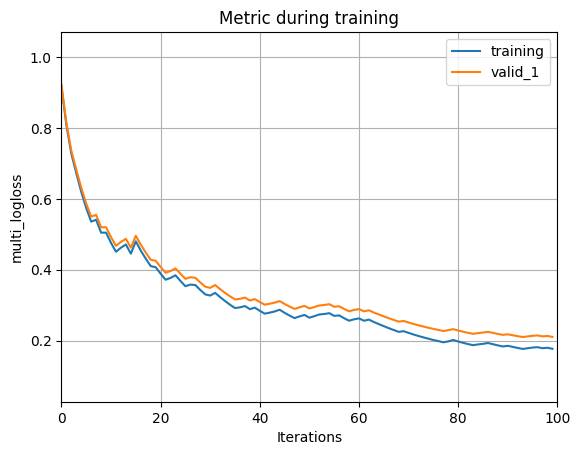

In [ ]:
lgb.plot_metric(booster=evals)

特徴量重要度を可視化

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

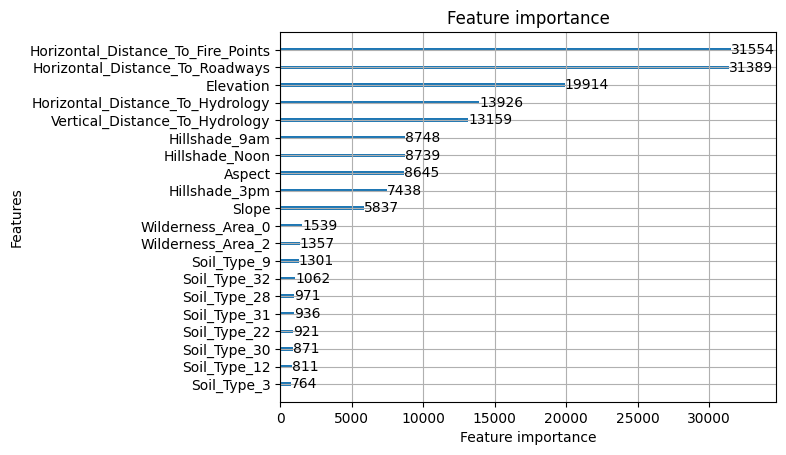

In [ ]:
lgb.plot_importance(gbm, max_num_features=20)

# 問2

## データ探索

In [ ]:
Soil_Types = pd.from_dummies(df.to_pandas().iloc[:,14:-1])
Wilderness_Areas = pd.from_dummies(df.to_pandas().iloc[:,10:14])

In [ ]:
df_cat = pl.concat([
    df[:, 0:10], pl.DataFrame({'Soil_Types':np.concatenate(Soil_Types.to_numpy())}), 
    pl.DataFrame({'Wilderness_Areas':np.concatenate(Wilderness_Areas.to_numpy())})
    ], 
    how='horizontal'
    )
df_cat

Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil_Types,Wilderness_Areas
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,object,object
2596,51,3,258,0,510,221,232,148,6279,Soil_Type_28,Wilderness_Area_0
2590,56,2,212,-6,390,220,235,151,6225,Soil_Type_28,Wilderness_Area_0
2804,139,9,268,65,3180,234,238,135,6121,Soil_Type_11,Wilderness_Area_0
2785,155,18,242,118,3090,238,238,122,6211,Soil_Type_29,Wilderness_Area_0
2595,45,2,153,-1,391,220,234,150,6172,Soil_Type_28,Wilderness_Area_0
2579,132,6,300,-15,67,230,237,140,6031,Soil_Type_28,Wilderness_Area_0
2606,45,7,270,5,633,222,225,138,6256,Soil_Type_28,Wilderness_Area_0
2605,49,4,234,7,573,222,230,144,6228,Soil_Type_28,Wilderness_Area_0
2617,45,9,240,56,666,223,221,133,6244,Soil_Type_28,Wilderness_Area_0


In [ ]:
df_wil = df_cat.groupby('Wilderness_Areas')\
.agg([
    pl.count(),
    pl.col('Horizontal_Distance_To_Roadways'),
    pl.col('Horizontal_Distance_To_Fire_Points'),
    pl.col('Elevation'),
    pl.col('Horizontal_Distance_To_Hydrology')
])

df_wil

Wilderness_Areas,count,Horizontal_Distance_To_Roadways,Horizontal_Distance_To_Fire_Points,Elevation,Horizontal_Distance_To_Hydrology
object,u32,list[i64],list[i64],list[i64],list[i64]
Wilderness_Area_0,260796,"[510, 390, … 1170]","[6279, 6225, … 2250]","[2596, 2590, … 3250]","[258, 212, … 270]"
Wilderness_Area_3,36968,"[404, 509, … 532]","[300, 421, … 966]","[2011, 2022, … 2649]","[313, 391, … 553]"
Wilderness_Area_1,29884,"[722, 750, … 127]","[1507, 1200, … 5650]","[3007, 2981, … 3124]","[124, 30, … 201]"
Wilderness_Area_2,253364,"[849, 1214, … 67]","[1521, 1719, … 875]","[2621, 2664, … 2383]","[60, 60, … 60]"


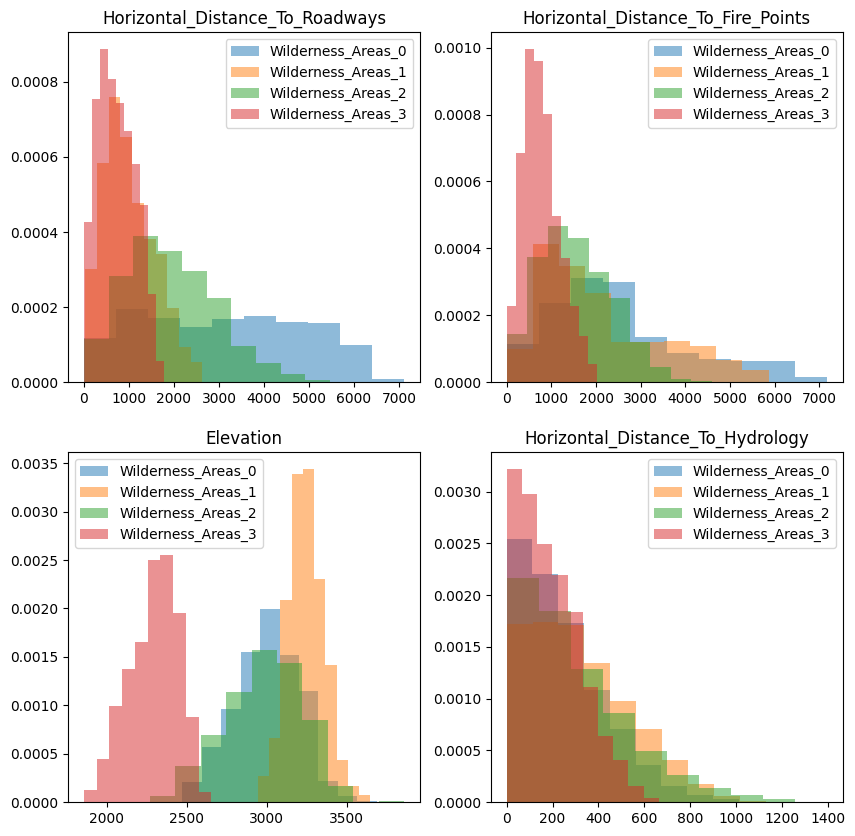

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10),
                      ncols=2, nrows=2, sharex=False, sharey=False)
for index, data in df_wil.to_pandas().iterrows():
    ax[0,0].hist(data['Horizontal_Distance_To_Roadways'], density=True, alpha=0.5, label=f'Wilderness_Areas_{index}')
    ax[0,0].legend()
    ax[0,0].set_title('Horizontal_Distance_To_Roadways')

for index, data in df_wil.to_pandas().iterrows():
    ax[0,1].hist(data['Horizontal_Distance_To_Fire_Points'], density=True, alpha=0.5, label=f'Wilderness_Areas_{index}')
    ax[0,1].legend()
    ax[0,1].set_title('Horizontal_Distance_To_Fire_Points')

for index, data in df_wil.to_pandas().iterrows():
    ax[1,0].hist(data['Elevation'], density=True, alpha=0.5, label=f'Wilderness_Areas_{index}')
    ax[1,0].legend()
    ax[1,0].set_title('Elevation')

for index, data in df_wil.to_pandas().iterrows():
    ax[1,1].hist(data['Horizontal_Distance_To_Hydrology'], density=True, alpha=0.5, label=f'Wilderness_Areas_{index}')
    ax[1,1].legend()
    ax[1,1].set_title('Horizontal_Distance_To_Hydrology')

カテゴリ化したデータフレームを保存する

In [ ]:
# 元のデータフレームを読み込む
df_c = pd.read_csv('./data/covtype_copy.data')

# ダミー変数の列を削除し、重複を削除したユニークなカテゴリ値のリストを取得する
# cat_cols = ['col1', 'col2', 'col3']  # カテゴリ変数の列名を指定
df_cat = df_c.iloc[:, 0:10]  # カテゴリ変数以外の列を抽出
cat_values = df_c.iloc[:,10:14].drop_duplicates().values.tolist()  # カテゴリ変数のユニークな値をリスト化

# 新しいカテゴリ変数列を作成する
df_cat['Wilderness_Areas'] = df_c.iloc[:,10:14].apply(lambda x: cat_values.index(x.values.tolist()), axis=1)  # カテゴリ変数の値をインデックスに変換


cat_values = df_c.iloc[:,14:-1].drop_duplicates().values.tolist() 
df_cat['Soil_Types'] = df_c.iloc[:,14:-1].apply(lambda x: cat_values.index(x.values.tolist()), axis=1)


df_cat['Cover_Type'] = df_c.iloc[:,-1]

df_cat

/var/folders/ng/b98db55j0msdb5ddc0lr6sh40000gn/T/ipykernel_68822/976599300.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat['Wilderness_Areas'] = df_c.iloc[:,10:14].apply(lambda x: cat_values.index(x.values.tolist()), axis=1)  # カテゴリ変数の値をインデックスに変換
/var/folders/ng/b98db55j0msdb5ddc0lr6sh40000gn/T/ipykernel_68822/976599300.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat['Soil_Types'] = df_c.iloc[:,14:-1].apply(lambda x: cat_values.index(x.values.tolist()), axis=1)
/var/folders/ng/b98db5

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Areas,Soil_Types,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,0,1,2
3,2785,155,18,242,118,3090,238,238,122,6211,0,2,2
4,2595,45,2,153,-1,391,220,234,150,6172,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,1,25,3
581008,2391,152,19,67,12,95,240,237,119,845,1,25,3
581009,2386,159,17,60,7,90,236,241,130,854,1,25,3
581010,2384,170,15,60,5,90,230,245,143,864,1,25,3


In [ ]:
df_cat.to_csv('./data/df_cat.csv', index=False)

# multilevel 

In [29]:
# df_cat = pd.read_csv('./data/df_cat.csv')
df_cat = pd.read_csv('./drive/MyDrive/Learning/CA_tech//df_cat.csv')

In [30]:
X = df_cat.drop(['Cover_Type'], axis=1)
y = df_cat['Cover_Type']

In [31]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.99, random_state=1013)

In [32]:
Wilderness_names = X_train.iloc[0:2, -44:-40].columns.values
Wilderness_names

array(['Wilderness_Area_0', 'Wilderness_Area_1', 'Wilderness_Area_2',
       'Wilderness_Area_3'], dtype=object)

In [33]:
fire = X_train['Horizontal_Distance_To_Fire_Points']

In [34]:
preds_name = X_train.drop(['Wilderness_Area_0', 'Wilderness_Area_1', 
                                         'Wilderness_Area_2', 'Wilderness_Area_3'], axis=1).columns.values
COORDS = {'Wil': Wilderness_names}

with pm.Model(coords=COORDS) as multimodel:
    # data
    Wil_ind = pm.MutableData('Wil_ind', X_train2['Wilderness_Areas'].values)
    
    # priors
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_a = pm.Normal('mu_a', mu=0, sigma=10)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=10.0)
    sigma_b = pm.HalfCauchy("sigma_b", 5)

    # Random intercept
    alpha = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, dims='Wil')
    # Random slopes
    beta = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims='Wil')

    
    # data likelihood
    logit_y = alpha[Wil_ind] + pm.math.dot(fire, beta[Wil_ind])
    y_obs = pm.Categorical('y_obs', logit_p=logit_y, observed=y_train_dummies)


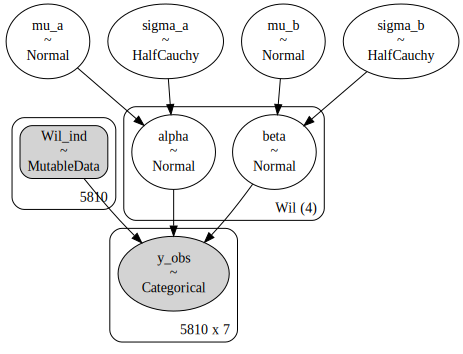

In [35]:
pm.model_to_graphviz(multimodel)

In [36]:
with multimodel:
    multimodel_trace = pmjax.sample_numpyro_nuts(tune=2000, chains=2, random_seed=RANDOM_SEED)

Compiling...


/usr/local/lib/python3.9/dist-packages/pymc/sampling/jax.py:641: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:07.405491
Sampling...


sample: 100%|██████████| 3000/3000 [19:16<00:00,  2.60it/s, 729 steps of size 1.43e-03. acc. prob=0.84]


Sampling time =  0:23:59.723272
Transforming variables...
Transformation time =  0:00:00.015264


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

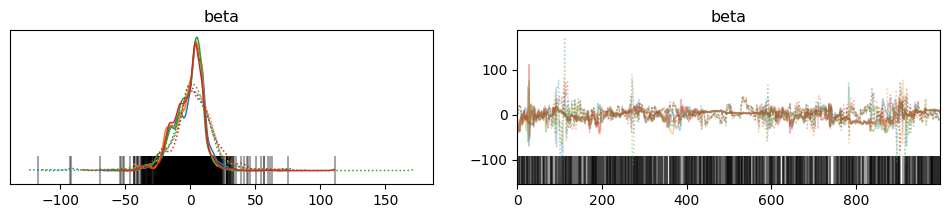

In [41]:
az.plot_trace(multimodel_trace, var_names=['beta'])

In [42]:
az.summary(multimodel_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_a,-1.118,8.964,-17.971,13.780,1.051,0.746,73.0,64.0,1.05
mu_b,0.306,9.721,-19.227,16.637,1.159,0.823,73.0,203.0,1.02
alpha[Wilderness_Area_0],99.755,174.132,-33.748,348.927,26.480,18.852,19.0,83.0,1.10
alpha[Wilderness_Area_1],-18.228,118.591,-209.104,185.504,7.520,9.201,194.0,106.0,1.07
alpha[Wilderness_Area_2],-18.705,107.980,-228.368,168.694,8.424,5.967,169.0,96.0,1.07
alpha[Wilderness_Area_3],-9.854,93.997,-202.891,135.156,8.226,5.829,128.0,111.0,1.07
beta[Wilderness_Area_0],0.427,16.616,-31.732,24.159,1.010,0.976,163.0,310.0,1.01
beta[Wilderness_Area_1],0.378,14.782,-25.557,28.029,1.212,0.859,113.0,219.0,1.02
beta[Wilderness_Area_2],-0.668,15.673,-26.970,24.739,1.169,0.828,112.0,188.0,1.01
beta[Wilderness_Area_3],1.115,14.537,-23.142,30.982,1.106,0.783,131.0,235.0,1.02


In [49]:
with multimodel:
    post = pm.sample_posterior_predictive(multimodel_trace)

In [65]:
post.posterior_predictive['y_obs'].mean(dim=["chain", "draw"])

<xarray.DataArray 'y_obs' (y_obs_dim_2: 5810, y_obs_dim_3: 7)>
array([[2962.552 , 3009.291 , 2915.509 , ..., 2949.1625, 2986.3135,
        2934.2745],
       [2911.3375, 2891.637 , 2970.7115, ..., 2902.709 , 2902.2375,
        2957.0135],
       [2921.169 , 2886.235 , 2947.494 , ..., 2970.9035, 2886.0375,
        2942.6065],
       ...,
       [2901.2355, 2941.981 , 2935.7775, ..., 2923.281 , 2941.5105,
        2910.3175],
       [2888.622 , 2910.996 , 2961.8155, ..., 2948.765 , 2889.3135,
        2922.722 ],
       [2963.4075, 2962.3255, 2943.092 , ..., 2917.514 , 2894.0305,
        2965.554 ]])
Coordinates:
  * y_obs_dim_2  (y_obs_dim_2) int64 0 1 2 3 4 5 ... 5805 5806 5807 5808 5809
  * y_obs_dim_3  (y_obs_dim_3) int64 0 1 2 3 4 5 6

In [71]:
np.mean(np.argmax(post.posterior_predictive['y_obs'].mean(dim=["chain", "draw"]).values, axis=1) == y_train.values)

0.14527036594867299

# 縮小事前分布（正則化）

In [11]:
COORDS = {
    'preds': X_train.columns.values,
    'class': list(np.ones(7)),
    'obs_id': list(np.ones(len(X_train)))
    }
with pm.Model(coords=COORDS) as shrinkage:
    # X = pm.MutableData('X', X_train, dims=('obs_id', 'preds'))
    
    # local shirinkage param
    nu_k = pm.InverseGamma('nu_k', 0.5, 1, dims=('preds','class'))
    lam_k2 = pm.InverseGamma('lam_k2', 0.5, 1/nu_k, dims=('preds','class'))
    
    # global shrinkage param
    xi = pm.InverseGamma('xi', 0.5, 1)
    tau2 = pm.InverseGamma('tau2', 0.5, 1/xi)
    
    # prior
    sigma = pm.HalfCauchy("sigma", 5)
    beta = pm.Normal('beta', 0, pm.math.sqrt(lam_k2)*pm.math.sqrt(tau2)*sigma,
                    dims=('preds','class'))
    
    # likelihood
    mu = pm.math.dot(X_train, beta)
    # link function
    p_y = pm.math.softmax(mu)
    y_like = pm.Bernoulli('y_like', p=p_y, observed = y_train_dummies, dims=('obs_id', 'class'))

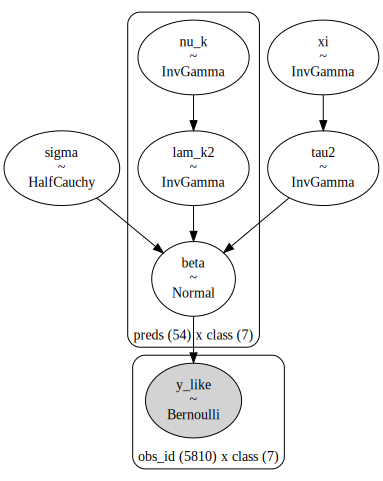

In [12]:
pm.model_to_graphviz(shrinkage)

In [13]:
with shrinkage:
    shrinkage_trace = pmjax.sample_numpyro_nuts(tune=2000, chains=2, random_seed=RANDOM_SEED)

Compiling...


/usr/local/lib/python3.9/dist-packages/pymc/sampling/jax.py:641: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(


Compilation time =  0:00:03.827509
Sampling...


sample: 100%|██████████| 3000/3000 [27:09<00:00,  1.84it/s, 1023 steps of size 2.89e-04. acc. prob=0.92]


Sampling time =  0:57:44.196969
Transforming variables...
Transformation time =  0:00:00.257413


In [21]:
az.rhat(shrinkage_trace)

<xarray.Dataset>
Dimensions:  (preds: 54, class: 7)
Coordinates:
  * preds    (preds) <U34 'Elevation' 'Aspect' ... 'Soil_Type_38' 'Soil_Type_39'
  * class    (class) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0
Data variables:
    beta     (preds, class) float64 1.905 1.852 2.231 ... 2.443 2.085 2.759
    nu_k     (preds, class) float64 2.296 2.425 2.318 ... 2.198 1.962 1.724
    lam_k2   (preds, class) float64 2.254 2.253 2.325 ... 2.055 2.114 2.326
    xi       float64 2.218
    tau2     float64 2.733
    sigma    float64 2.974

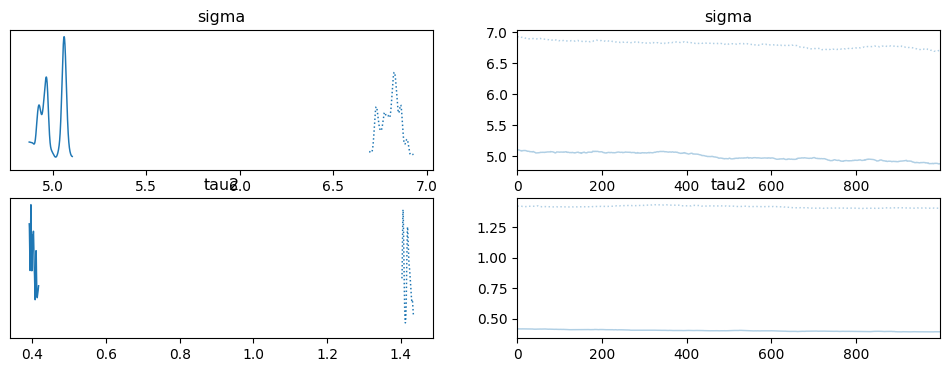

In [20]:
az.plot_trace(shrinkage_trace, var_names=["sigma", "tau2"]);